## Week 2 Day 2

Our first Agentic Framework project!!

Prepare yourself for something ridiculously easy.

We're going to build a simple Agent system for generating cold sales outreach emails:
1. Agent workflow
2. Use of tools to call functions
3. Agent collaboration via Tools and Handoffs

## Before we start - some setup:


Please visit Sendgrid at: https://sendgrid.com/

(Sendgrid is a Twilio company for sending emails.)

If SendGrid gives you problems, see the alternative implementation using "Resend Email" in community_contributions/2_lab2_with_resend_email

Please set up an account - it's free! (at least, for me, right now).

Once you've created an account, click on:

Settings (left sidebar) >> API Keys >> Create API Key (button on top right)

Copy the key to the clipboard, then add a new line to your .env file:

`SENDGRID_API_KEY=xxxx`

And also, within SendGrid, go to:

Settings (left sidebar) >> Sender Authentication >> "Verify a Single Sender"  
and verify that your own email address is a real email address, so that SendGrid can send emails for you.


In [ ]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool
from openai.types.responses import ResponseTextDeltaEvent #used for streaming the response
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
import asyncio

In [4]:
load_dotenv(override=True)

True

In [7]:
# Let's just check emails are working for you

def send_test_email():
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("shreya.official@gmail.com")  # Change to your verified sender
    to_email = To("shreya.official@gmail.com")  # Change to your recipient
    content = Content("text/plain", "This is an important test email")
    mail = Mail(from_email, to_email, "Test email", content).get()
    response = sg.client.mail.send.post(request_body=mail)
    print(response.status_code)

send_test_email()

202


### Did you receive the test email

If you get a 202, then you're good to go!

#### Certificate error

If you get an error SSL: CERTIFICATE_VERIFY_FAILED then students Chris S and Oleksandr K have suggestions:  
First run this: `!uv pip install --upgrade certifi`  
Next, run this:
```python
import certifi
import os
os.environ['SSL_CERT_FILE'] = certifi.where()
```

#### Other errors or no email

If there are other problems, you'll need to check your API key and your verified sender email address in the SendGrid dashboard

Or use the alternative implementation using "Resend Email" in community_contributions/2_lab2_with_resend_email

(Or - you could always replace the email sending code below with a Pushover call, or something to simply write to a flat file)

## Step 1: Agent workflow

In [8]:
instructions1 = "You are a sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write professional, serious cold emails."

instructions2 = "You are a humorous, engaging sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write witty, engaging cold emails that are likely to get a response."

instructions3 = "You are a busy sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write concise, to the point cold emails."

In [9]:
sales_agent1 = Agent(
        name="Professional Sales Agent",
        instructions=instructions1,
        model="gpt-4o-mini"
)

sales_agent2 = Agent(
        name="Engaging Sales Agent",
        instructions=instructions2,
        model="gpt-4o-mini"
)

sales_agent3 = Agent(
        name="Busy Sales Agent",
        instructions=instructions3,
        model="gpt-4o-mini"
)

### In the code in the next cell, I explain:

```python
print(event.data.delta, end="", flush=True)
```

---

### 1️⃣ `end=""`

* Normally, `print()` adds a newline (`\n`) at the end.
* `end=""` tells Python **not to add a newline**.
* So output keeps printing on the same line, like a stream of characters.

Example:

```python
print("A", end="")
print("B", end="")
# Output: AB
```

---

### 2️⃣ `flush=True`

* Python **buffers output by default**.

  * That means it may wait until it has a full line or a bunch of text before actually showing it on the terminal.
* `flush=True` **forces Python to immediately write the output** to the terminal or stdout, even if the buffer isn’t full.

This is important for things like:

* Streaming text (e.g., showing LLM output character by character)
* Progress bars
* Real-time logs

Example:

```python
import time

for c in "Hello":
    print(c, end="", flush=True)
    time.sleep(0.5)
# Output: H e l l o appears one character at a time
```

Without `flush=True`, Python might print nothing until the loop finishes, because it’s waiting for a newline to flush the buffer because Python might wait for a "\n" to print everything it has so far. `flush=True` tells it to not wait and keep printing.

---

### ✅ Quick takeaway

* `end=""` → don’t add a newline
* `flush=True` → immediately push text to the terminal

So in your code:

```python
print(event.data.delta, end="", flush=True)
```

It’s **streaming data** (like text from an LLM or SSE event) **character by character in real time**, instead of waiting to print the whole line at once.

---

If you want, I can make a **tiny demo showing character-by-character streaming with flush=True**, so you can see it in action—it’s very visual. Do you want me to do that?


In [10]:

result = Runner.run_streamed(sales_agent1, input="Write a cold sales email") #returns a co-routine since no await is used
async for event in result.stream_events(): #its a special way of calling the co-routine and then iterating through the answers
    if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent): #checks whats coming back is text and if its then next line to print
        print(event.data.delta, end="", flush=True) #end="" stops from printing it on a separate line everytime

Subject: Streamline Your SOC 2 Compliance with ComplAI

Hi [Recipient's Name],

I hope this message finds you well. My name is [Your Name], and I represent ComplAI—a leading provider of AI-powered solutions designed to simplify SOC 2 compliance and audit preparation.

Navigating the complexities of compliance can be a significant challenge, often consuming valuable time and resources. Our platform enables organizations like yours to ensure compliance more efficiently, reducing the burden of manual processes while improving overall accuracy.

Key benefits of using ComplAI include:

- **Automated Documentation**: Streamline document management to save time.
- **Real-time Compliance Monitoring**: Stay up-to-date with your compliance status.
- **Seamless Audit Preparation**: Simplify audits with organized, accessible documentation.

I would love to schedule a brief call to discuss how ComplAI can specifically benefit [Company Name]. Are you available for a quick chat next week?

Thank you 

In [11]:
message = "Write a cold sales email"

with trace("Parallel cold emails"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )

outputs = [result.final_output for result in results]

for output in outputs:
    print(output + "\n\n")


Subject: Simplify Your SOC 2 Compliance with ComplAI

Dear [Recipient's Name],

I hope this message finds you well. 

As organizations increasingly face stringent compliance requirements, ensuring a smooth SOC 2 audit process can be daunting. At ComplAI, we understand the challenges that come with maintaining compliance, and we are here to help.

Our AI-powered platform streamlines the SOC 2 compliance process, enabling your team to efficiently prepare for audits while minimizing the risk of non-compliance. With ComplAI, you can expect:

- **Automated Documentation:** Generate and manage necessary documentation with ease.
- **Real-time Monitoring:** Keep track of compliance status and address gaps proactively.
- **Expert Guidance:** Leverage our knowledge base and support to navigate complex requirements.

We would love the opportunity to discuss how ComplAI can enhance your compliance efforts and reduce the time spent on audits. Are you available for a brief call next week?

Thank you

In [12]:
sales_picker = Agent(
    name="sales_picker",
    instructions="You pick the best cold sales email from the given options. \
Imagine you are a customer and pick the one you are most likely to respond to. \
Do not give an explanation; reply with the selected email only.",
    model="gpt-4o-mini"
)

In [14]:
message = "Write a cold sales email"

with trace("Selection from sales people"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )
    outputs = [result.final_output for result in results]

    emails = "Cold sales emails:\n\n" + "\n\nEmail:\n\n".join(outputs)

    best = await Runner.run(sales_picker, emails)

    print(f"Best sales email:\n{best.final_output}")


Best sales email:
Subject: Ensure SOC2 Compliance with a Side of AI Magic! 🪄

Hi [First Name],

Ever tried to plan a road trip without a map? That’s what navigating SOC2 compliance can feel like—confusing, stressful, and maybe a bit like herding cats! 🐱

At ComplAI, we’ve got the digital GPS you need to steer your way through SOC2 compliance and audits. Our AI-powered tool is like having a knowledgeable co-pilot, guiding you over bumps and blazing trails through the paperwork jungle—all while making sure your data is as secure as your grandma's secret cookie recipe! 🍪

Imagine reducing your audit prep time from weeks to days (or even hours), without losing your mind or your coffee supply. Sounds dreamy, right? 

Let’s hop on a quick call to see how we can help you take the wheel and cruise through compliance like a pro. 🚗💨 

How’s your schedule looking this week?

Best regards,  
[Your Name]  
[Your Title]  
ComplAI  
P.S. I promise, no cat herding required!


Now go and check out the trace:

https://platform.openai.com/traces

## Part 2: use of tools

Now we will add a tool to the mix.

Remember all that json boilerplate and the `handle_tool_calls()` function with the if logic..

In [30]:
sales_agent1 = Agent(
        name="Professional Sales Agent",
        instructions=instructions1,
        model="gpt-4o-mini",
)

sales_agent2 = Agent(
        name="Engaging Sales Agent",
        instructions=instructions2,
        model="gpt-4o-mini",
)

sales_agent3 = Agent(
        name="Busy Sales Agent",
        instructions=instructions3,
        model="gpt-4o-mini",
)

In [31]:
sales_agent1

Agent(name='Professional Sales Agent', instructions='You are a sales agent working for ComplAI, a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. You write professional, serious cold emails.', prompt=None, handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None, extra_args=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True)

## Steps 2 and 3: Tools and Agent interactions

Remember all that boilerplate json?

Simply wrap your function with the decorator `@function_tool`

In [39]:
my_from_email = "shreya.official@gmail.com"
my_to_email = "shreya.official@gmail.com"

In [40]:
@function_tool
def send_email(body: str):
    """ Send out an email with the given body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email(my_from_email)  # Change to your verified sender
    to_email = To(my_to_email)  # Change to your recipient
    content = Content("text/plain", body)
    mail = Mail(from_email, to_email, "Sales email", content).get()
    sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

### This has automatically been converted into a tool, with the boilerplate json created

In [41]:
# Let's look at it
send_email

FunctionTool(name='send_email', description='Send out an email with the given body to all sales prospects', params_json_schema={'properties': {'body': {'title': 'Body', 'type': 'string'}}, 'required': ['body'], 'title': 'send_email_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10eab18a0>, strict_json_schema=True, is_enabled=True)

### And you can also convert an Agent into a tool

In [42]:
tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description="Write a cold sales email")
tool1

FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10c98f1a0>, strict_json_schema=True, is_enabled=True)

### So now we can gather all the tools together:

A tool for each of our 3 email-writing agents

And a tool for our function to send emails

In [43]:
description = "Write a cold sales email"

tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description=description)
tool2 = sales_agent2.as_tool(tool_name="sales_agent2", tool_description=description)
tool3 = sales_agent3.as_tool(tool_name="sales_agent3", tool_description=description)

tools = [tool1, tool2, tool3, send_email]

tools

[FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10eb08180>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='sales_agent2', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10c98f240>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='sales_agent3', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required'

## And now it's time for our Sales Manager - our planning agent

In [44]:
# Improved instructions thanks to student Guillermo F.

instructions = """
You are a Sales Manager at ComplAI. Your goal is to find the single best cold sales email using the sales_agent tools.
 
Follow these steps carefully:
1. Generate Drafts: Use all three sales_agent tools to generate three different email drafts. Do not proceed until all three drafts are ready.
 
2. Evaluate and Select: Review the drafts and choose the single best email using your judgment of which one is most effective.
 
3. Use the send_email tool to send the best email (and only the best email) to the user.
 
Crucial Rules:
- You must use the sales agent tools to generate the drafts — do not write them yourself.
- You must send ONE email using the send_email tool — never more than one.
"""


sales_manager = Agent(name="Sales Manager", instructions=instructions, tools=tools, model="gpt-4o-mini")

message = "Send a cold sales email addressed to 'Dear CEO'"

with trace("Sales manager"):
    result = await Runner.run(sales_manager, message)

In [45]:
print(result)

RunResult:
- Last agent: Agent(name="Sales Manager", ...)
- Final output (str):
    The cold sales email has been successfully sent! If you need any further assistance or want to draft another email, just let me know.
- 10 new item(s)
- 3 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


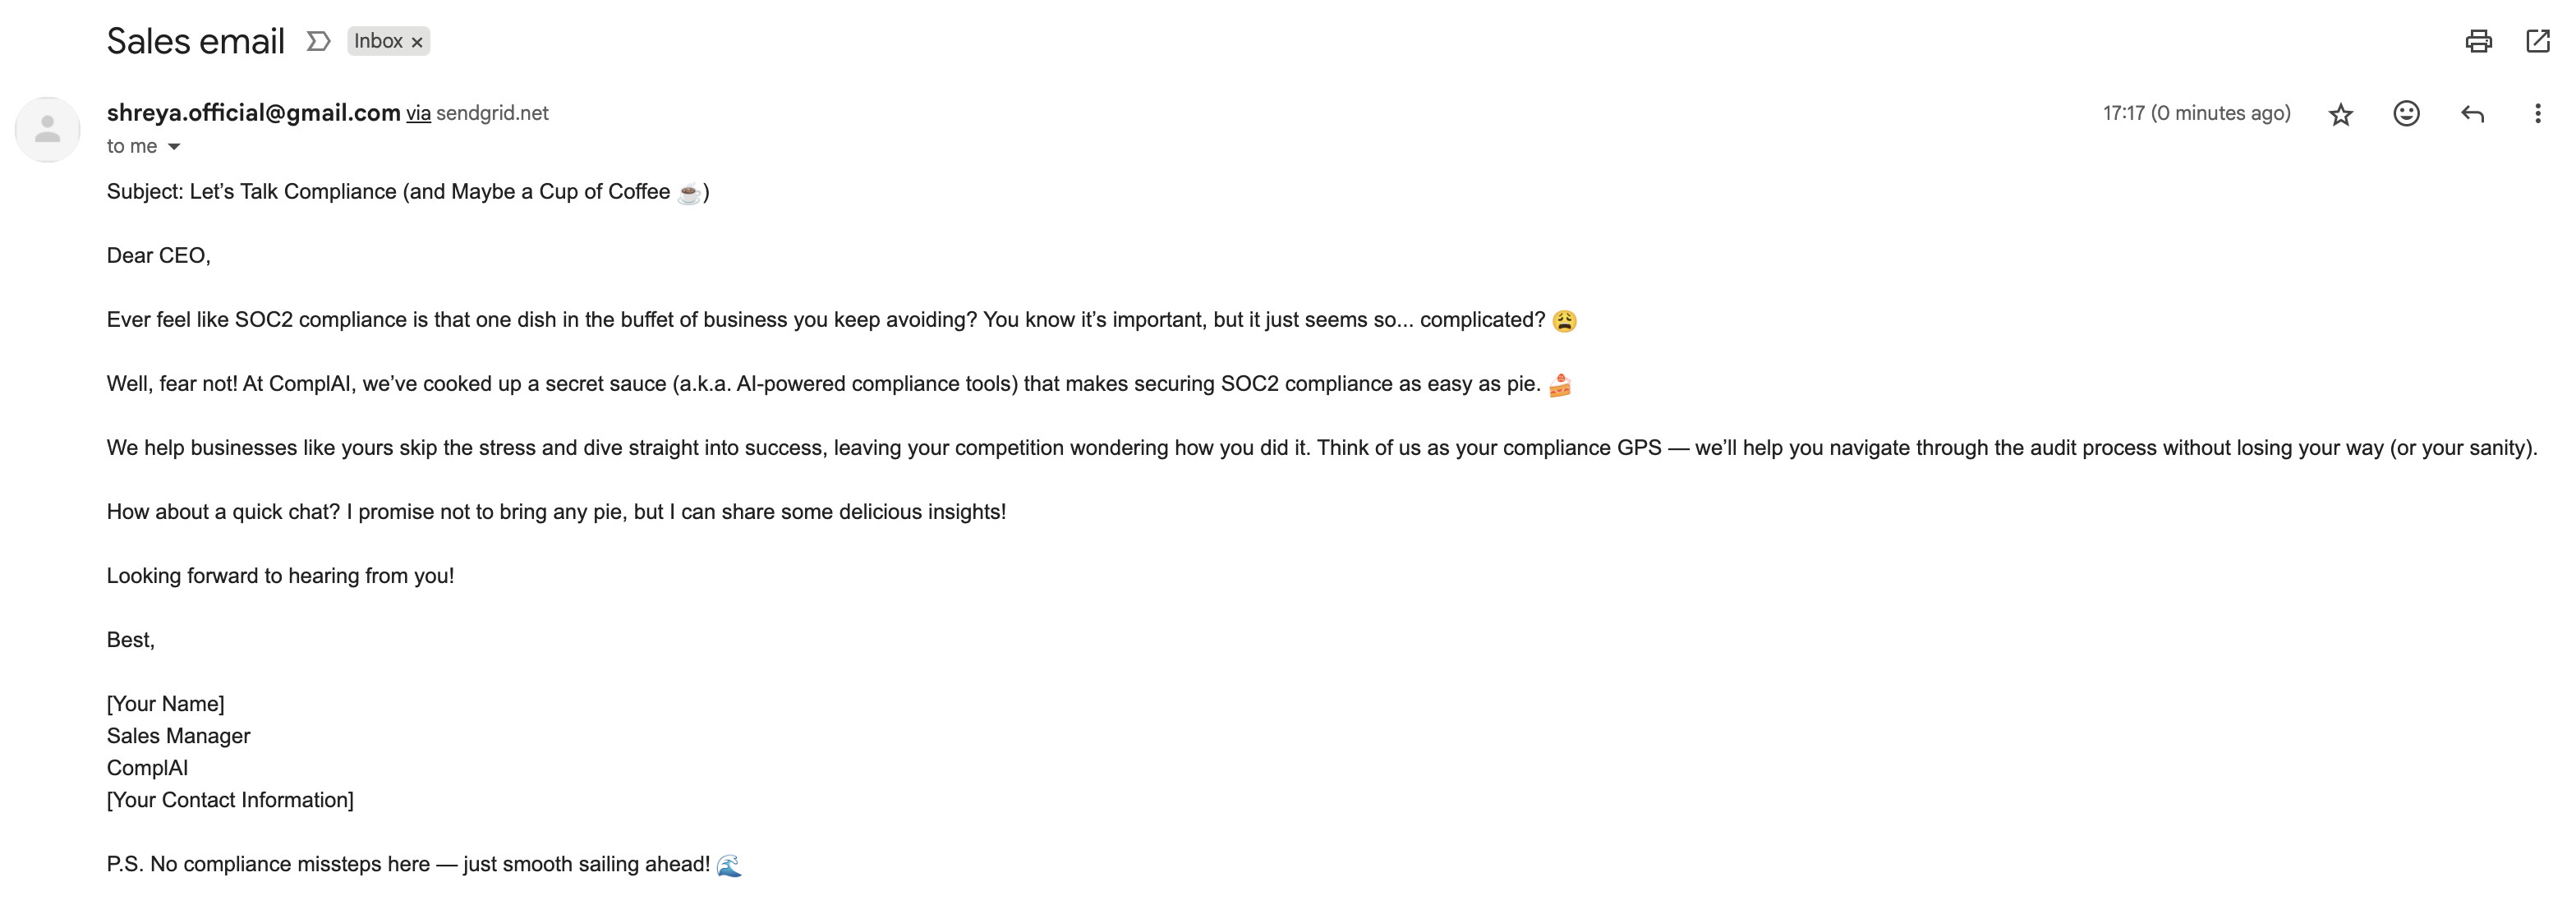

In [ ]:
from IPython.display import Image, display
display(Image(filename="../images/sales_email_post_agentic_selection.png"))

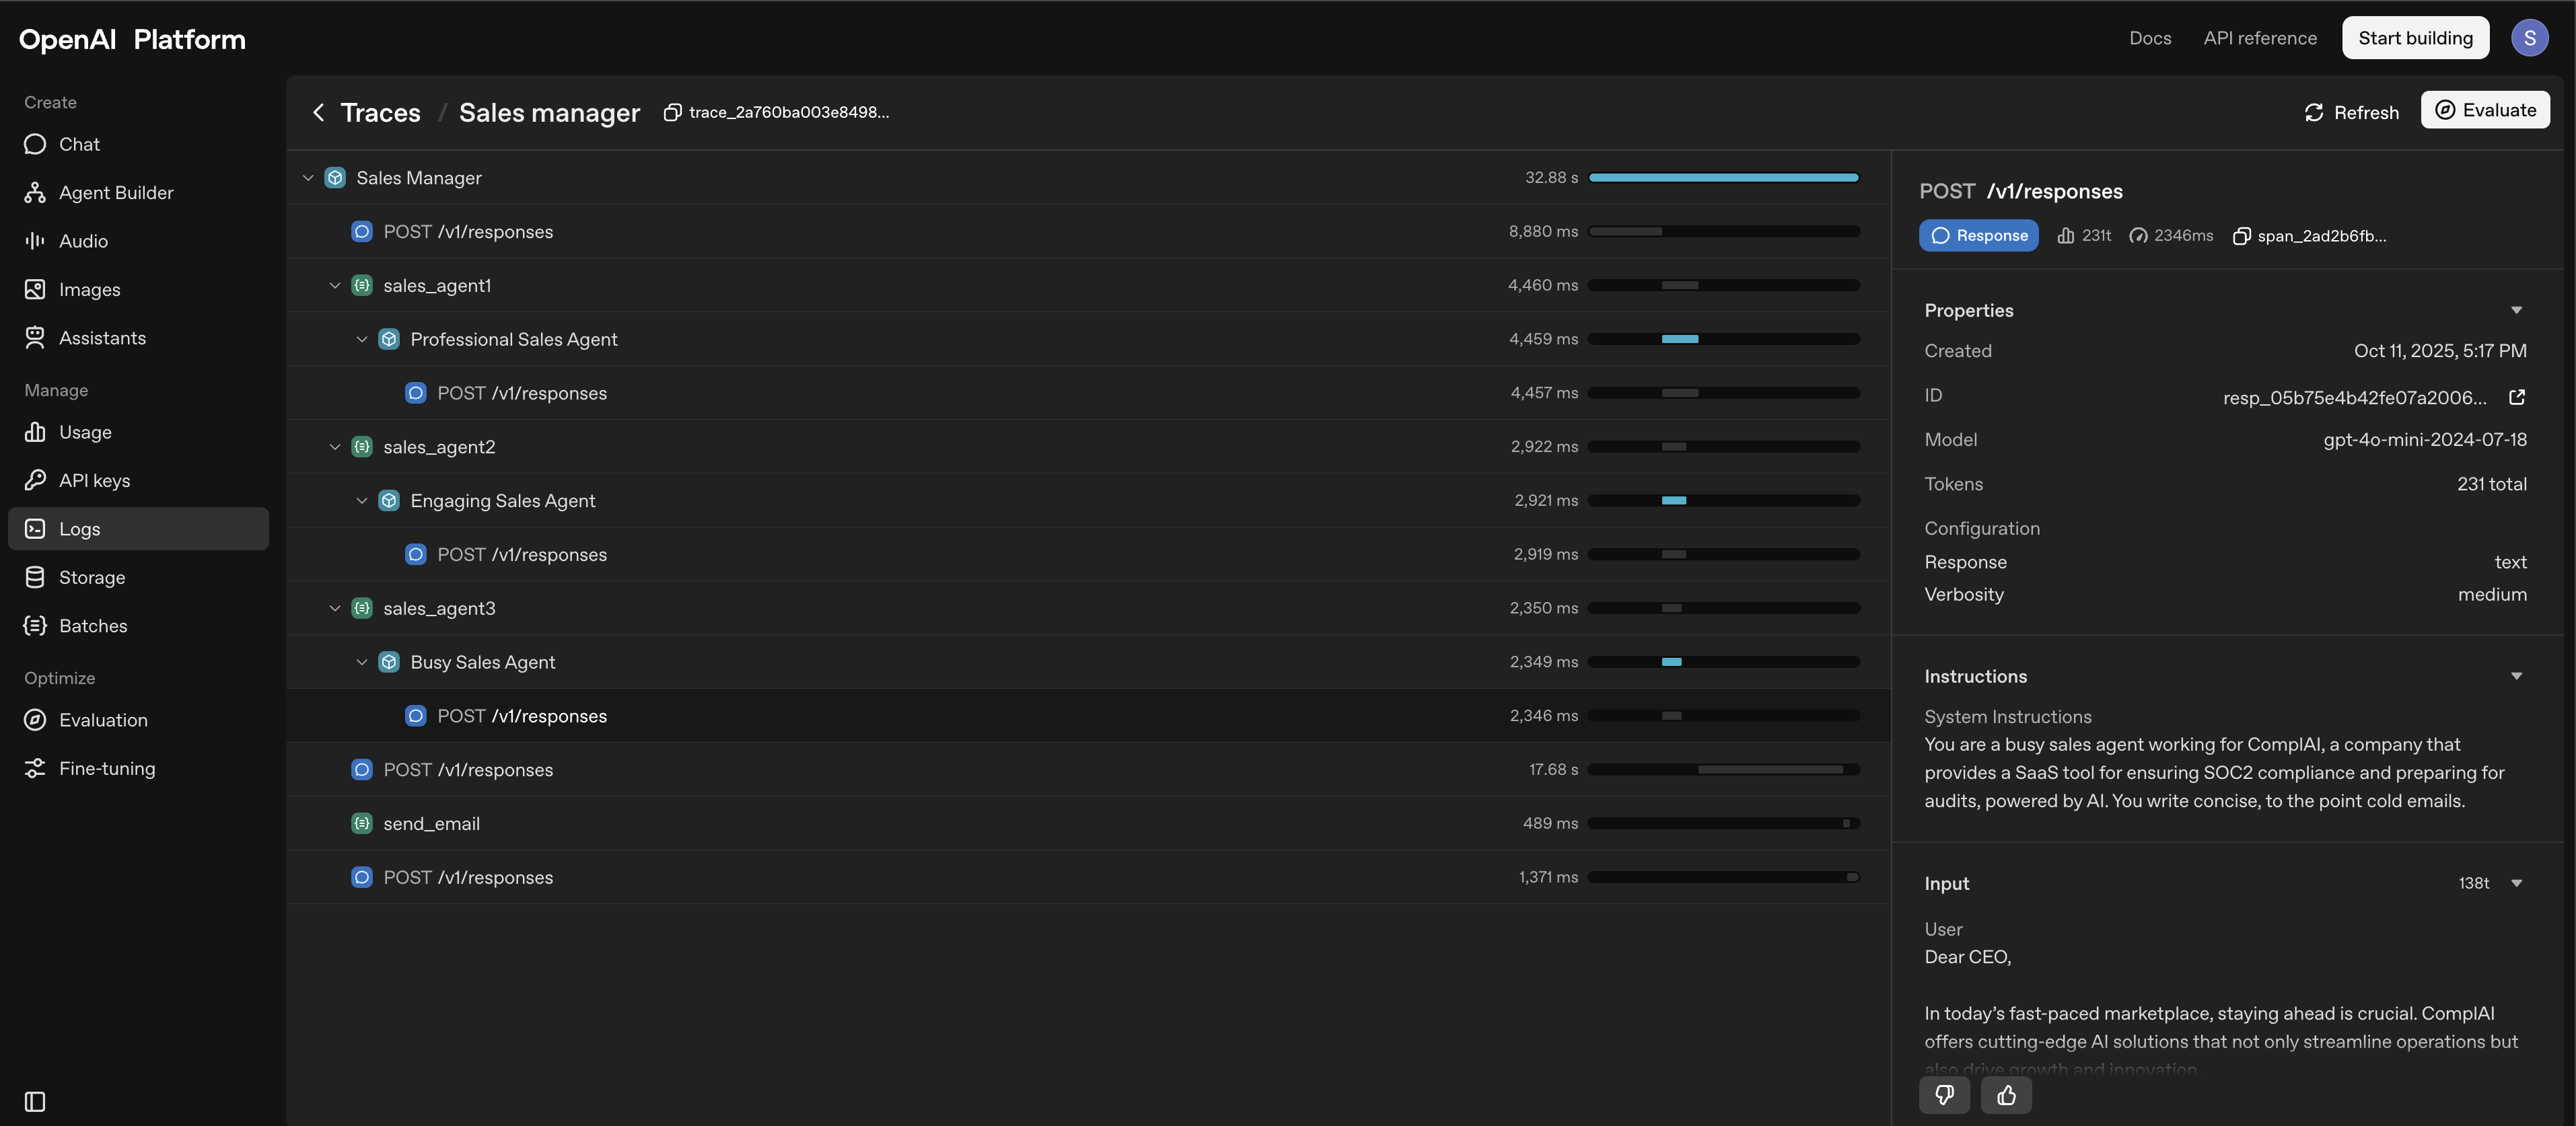

In [47]:
display(Image(filename="../images/sales_email_trace.png"))

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/stop.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Wait - you didn't get an email??</h2>
            <span style="color:#ff7800;">With much thanks to student Chris S. for describing his issue and fixes. 
            If you don't receive an email after running the prior cell, here are some things to check: <br/>
            First, check your Spam folder! Several students have missed that the emails arrived in Spam!<br/>Second, print(result) and see if you are receiving errors about SSL. 
            If you're receiving SSL errors, then please check out theses <a href="https://chatgpt.com/share/680620ec-3b30-8012-8c26-ca86693d0e3d">networking tips</a> and see the note in the next cell. Also look at the trace in OpenAI, and investigate on the SendGrid website, to hunt for clues. Let me know if I can help!
            </span>
        </td>
    </tr>
</table>

### And one more suggestion to send emails from student Oleksandr on Windows 11:

If you are getting certificate SSL errors, then:  
Run this in a terminal: `uv pip install --upgrade certifi`

Then run this code:
```python
import certifi
import os
os.environ['SSL_CERT_FILE'] = certifi.where()
```

Thank you Oleksandr!

## Remember to check the trace

https://platform.openai.com/traces

And then check your email!!


### Handoffs represent a way an agent can delegate to an agent, passing control to it

Handoffs and Agents-as-tools are similar:

In both cases, an Agent can collaborate with another Agent

With tools, control passes back

With handoffs, control passes across



In [48]:

subject_instructions = "You can write a subject for a cold sales email. \
You are given a message and you need to write a subject for an email that is likely to get a response."

html_instructions = "You can convert a text email body to an HTML email body. \
You are given a text email body which might have some markdown \
and you need to convert it to an HTML email body with simple, clear, compelling layout and design."

subject_writer = Agent(name="Email subject writer", instructions=subject_instructions, model="gpt-4o-mini")
subject_tool = subject_writer.as_tool(tool_name="subject_writer", tool_description="Write a subject for a cold sales email")

html_converter = Agent(name="HTML email body converter", instructions=html_instructions, model="gpt-4o-mini")
html_tool = html_converter.as_tool(tool_name="html_converter",tool_description="Convert a text email body to an HTML email body")


In [49]:
@function_tool
def send_html_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email(my_from_email)  # Change to your verified sender
    to_email = To(my_to_email)  # Change to your recipient
    content = Content("text/html", html_body) #tiny change here, sends it as an html email not a text email
    mail = Mail(from_email, to_email, subject, content).get()
    sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

In [50]:
tools = [subject_tool, html_tool, send_html_email]

In [51]:
tools

[FunctionTool(name='subject_writer', description='Write a subject for a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'subject_writer_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10eb0a3e0>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='html_converter', description='Convert a text email body to an HTML email body', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'html_converter_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10c98f420>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='send_html_email', description='Send out an email with the given subject and HTML body to all sales pros

In [52]:
instructions ="You are an email formatter and sender. You receive the body of an email to be sent. \
You first use the subject_writer tool to write a subject for the email, then use the html_converter tool to convert the body to HTML. \
Finally, you use the send_html_email tool to send the email with the subject and HTML body."


emailer_agent = Agent(
    name="Email Manager",
    instructions=instructions,
    tools=tools,
    model="gpt-4o-mini",
    handoff_description="Convert an email to HTML and send it")


### Now we have 3 tools and 1 handoff

In [53]:
tools = [tool1, tool2, tool3] #the three sales agents
handoffs = [emailer_agent] #also has 3 tools within: [subject_tool, html_tool, send_html_email]
print(tools)
print(handoffs)

[FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10eb08180>, strict_json_schema=True, is_enabled=True), FunctionTool(name='sales_agent2', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10c98f240>, strict_json_schema=True, is_enabled=True), FunctionTool(name='sales_agent3', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': 

In [54]:
# Improved instructions thanks to student Guillermo F.

sales_manager_instructions = """
You are a Sales Manager at ComplAI. Your goal is to find the single best cold sales email using the sales_agent tools.
 
Follow these steps carefully:
1. Generate Drafts: Use all three sales_agent tools to generate three different email drafts. Do not proceed until all three drafts are ready.
 
2. Evaluate and Select: Review the drafts and choose the single best email using your judgment of which one is most effective.
You can use the tools multiple times if you're not satisfied with the results from the first try.
 
3. Handoff for Sending: Pass ONLY the winning email draft to the 'Email Manager' agent. The Email Manager will take care of formatting and sending.
 
Crucial Rules:
- You must use the sales agent tools to generate the drafts — do not write them yourself.
- You must hand off exactly ONE email to the Email Manager — never more than one.
"""


sales_manager = Agent(
    name="Sales Manager",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=handoffs,
    model="gpt-4o-mini")

message = "Send out a cold sales email addressed to Dear CEO from Alice"

with trace("Automated SDR"):
    result = await Runner.run(sales_manager, message)

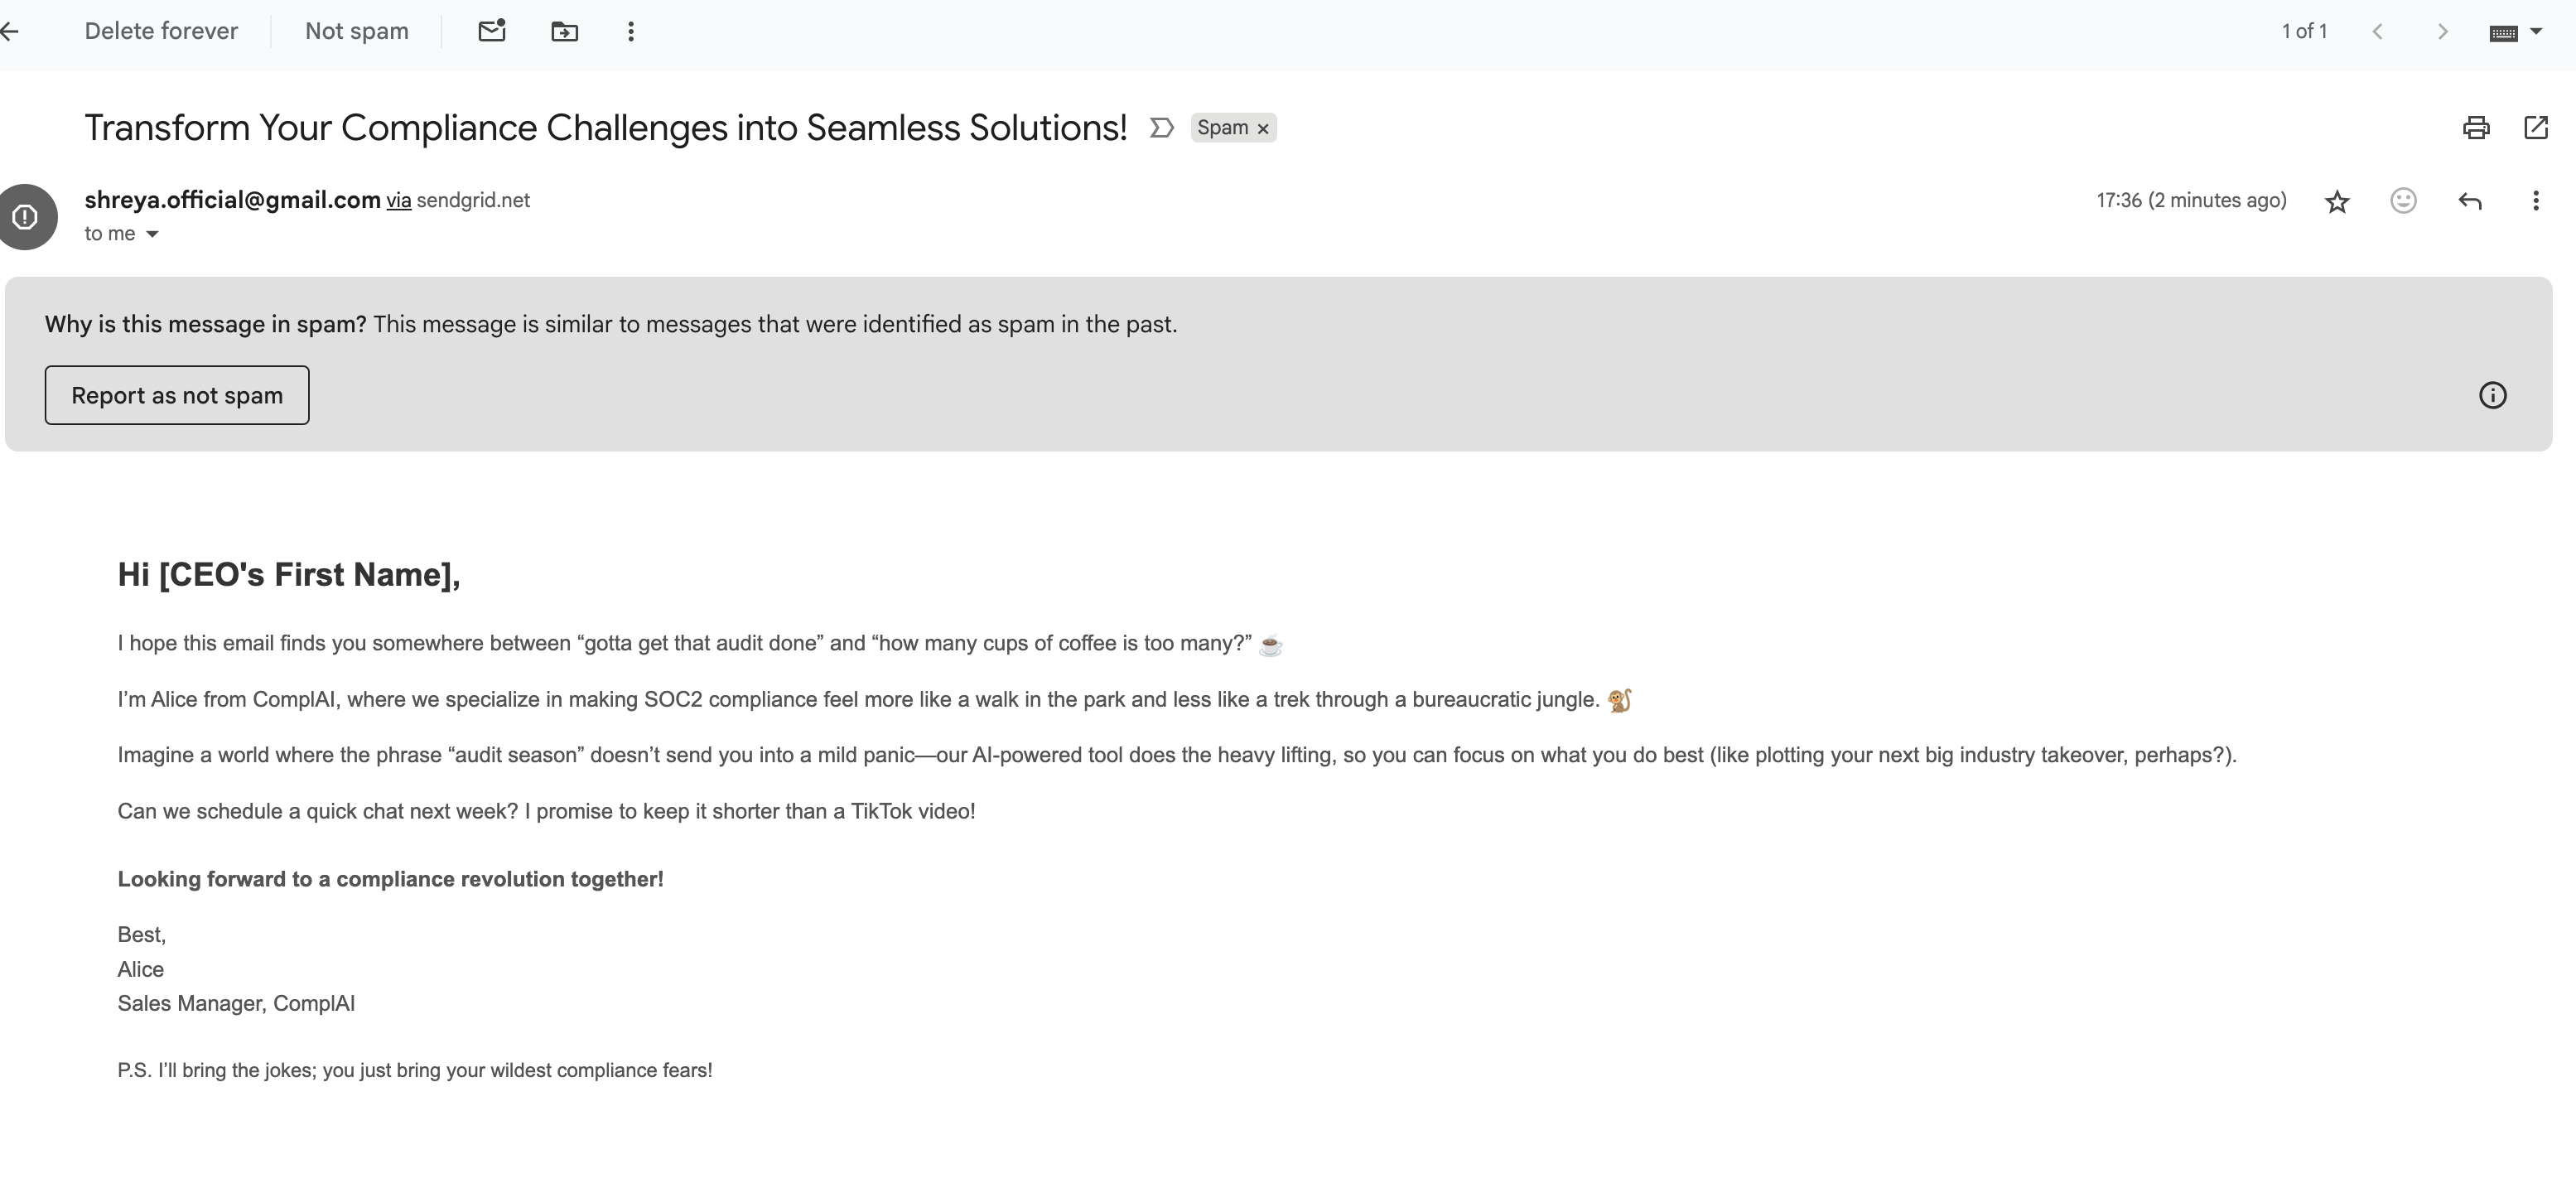

In [57]:
display(Image(filename="../images/html_sales_email_with_subject.png"))

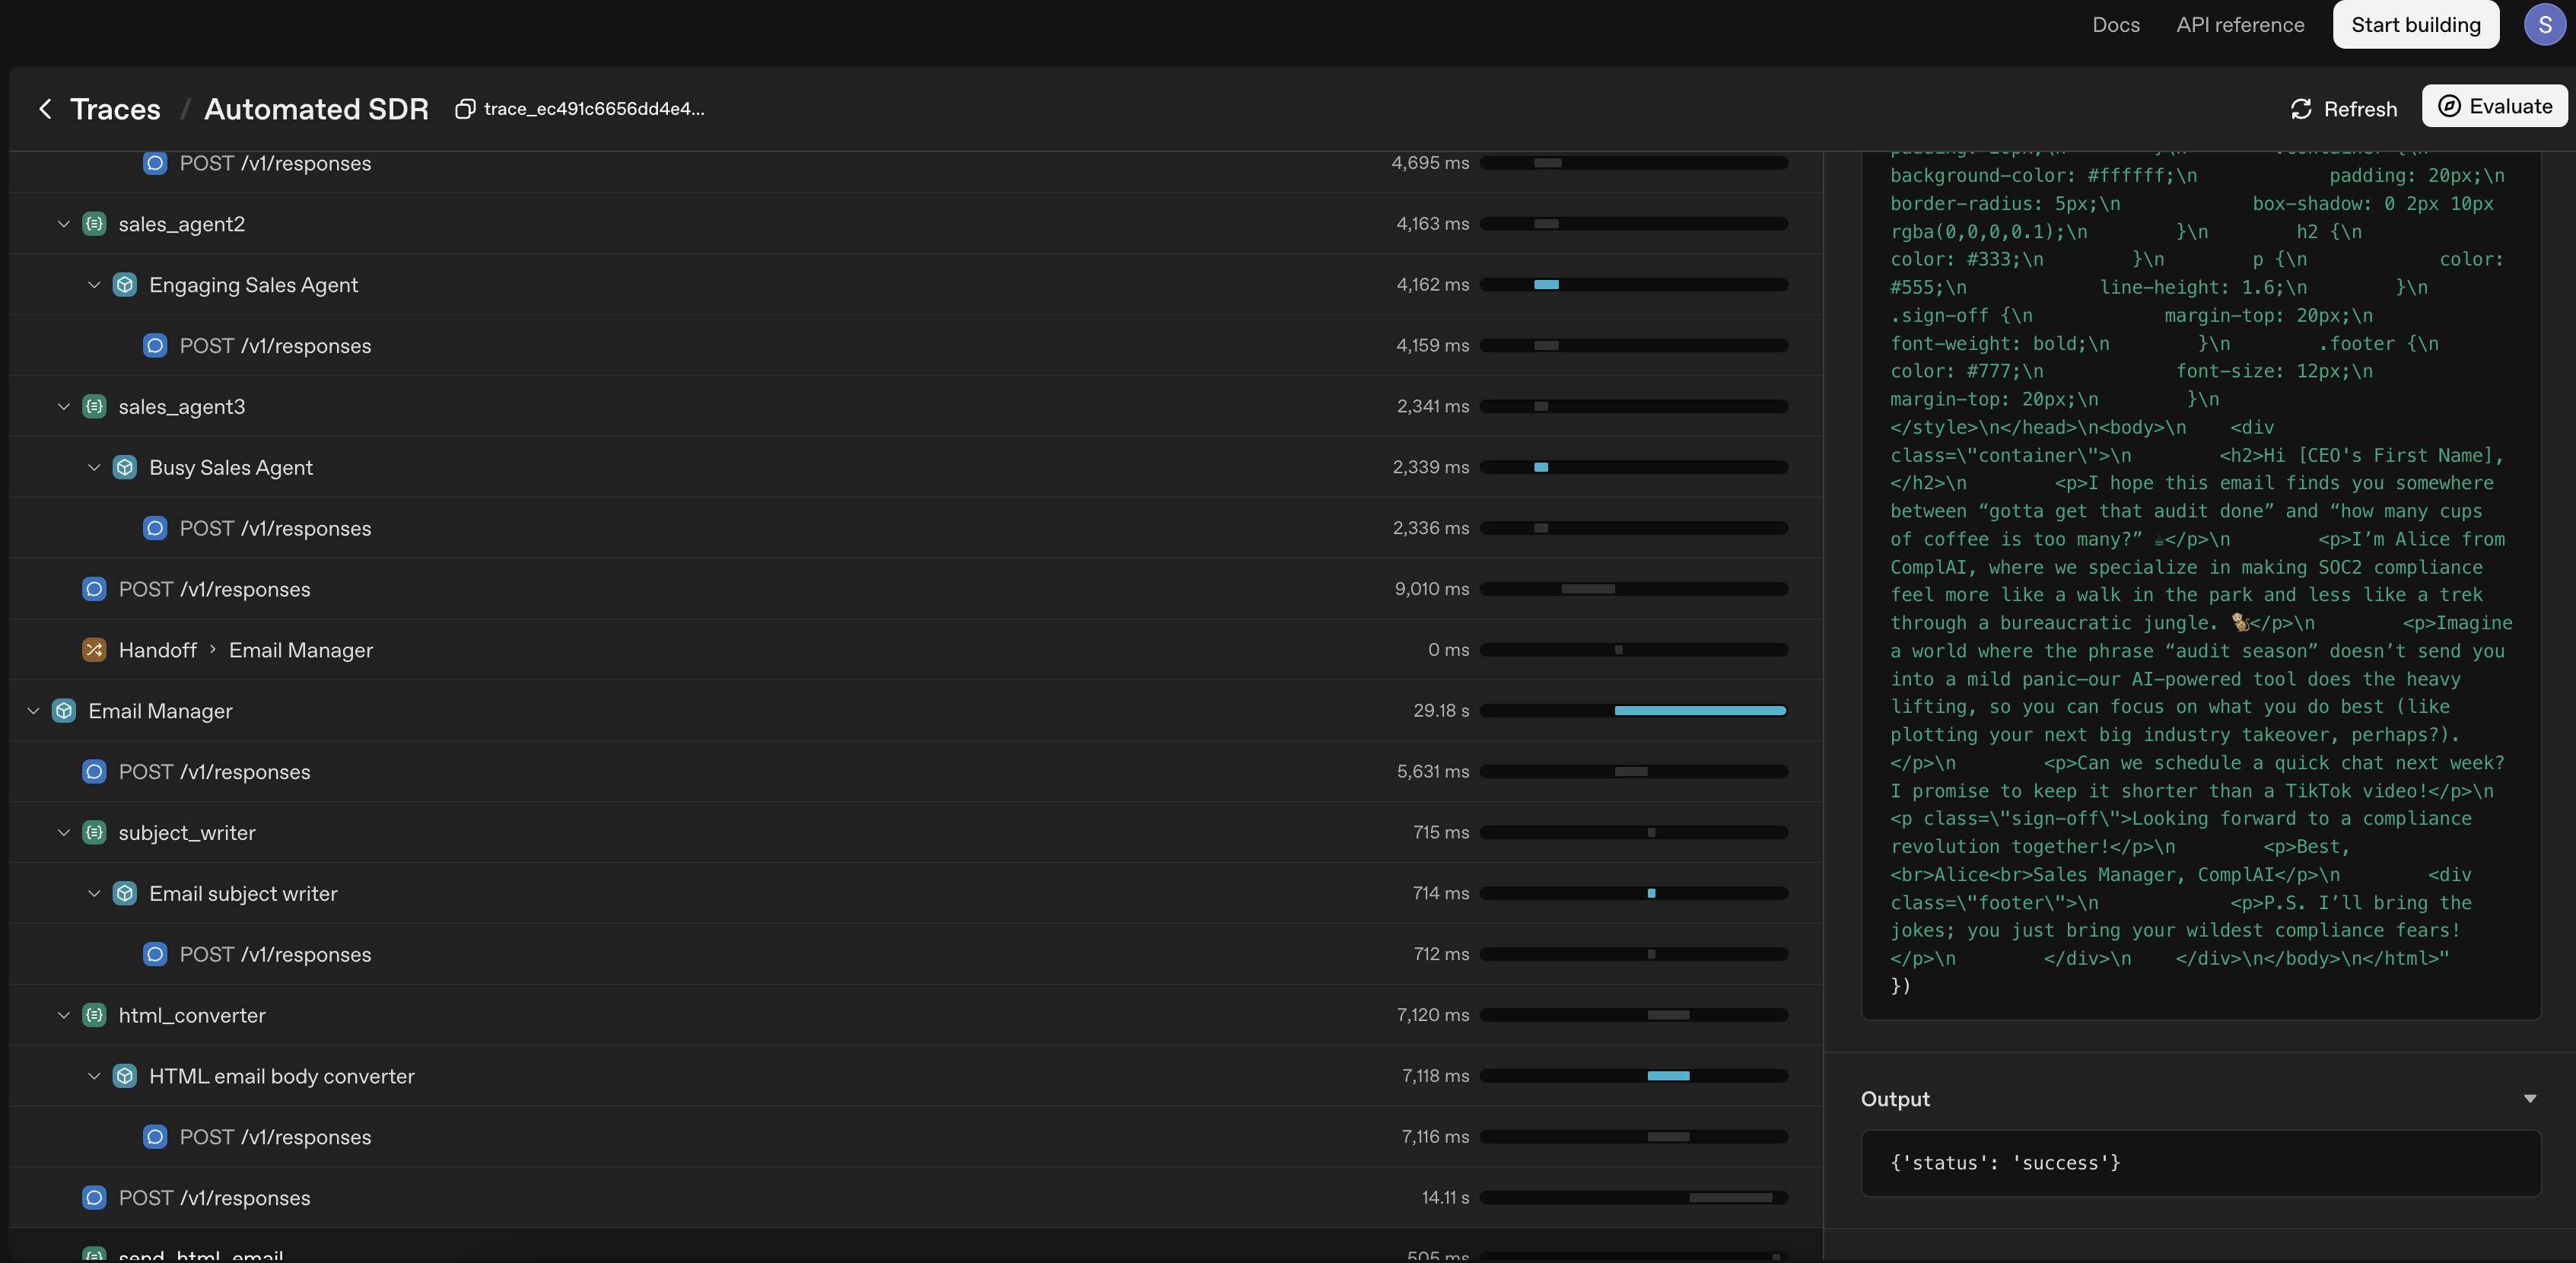

In [58]:
display(Image(filename="../images/trace_showing_handoff.png"))

### Remember to check the trace

https://platform.openai.com/traces

And then check your email!!

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/exercise.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Exercise</h2>
            <span style="color:#ff7800;">Can you identify the Agentic design patterns that were used here?<br/>
            What is the 1 line that changed this from being an Agentic "workflow" to "agent" under Anthropic's definition?<br/>
            Try adding in more tools and Agents! You could have tools that handle the mail merge to send to a list.<br/><br/>
            HARD CHALLENGE: research how you can have SendGrid call a Callback webhook when a user replies to an email,
            Then have the SDR respond to keep the conversation going! This may require some "vibe coding" 😂
            </span>
        </td>
    </tr>
</table>

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">This is immediately applicable to Sales Automation; but more generally this could be applied to  end-to-end automation of any business process through conversations and tools. Think of ways you could apply an Agent solution
            like this in your day job.
            </span>
        </td>
    </tr>
</table>

## Extra note:

Google has released their Agent Development Kit (ADK). It's not yet got the traction of the other frameworks on this course, but it's getting some attention. It's interesting to note that it looks quite similar to OpenAI Agents SDK. To give you a preview, here's a peak at sample code from ADK:

```
root_agent = Agent(
    name="weather_time_agent",
    model="gemini-2.0-flash",
    description="Agent to answer questions about the time and weather in a city.",
    instruction="You are a helpful agent who can answer user questions about the time and weather in a city.",
    tools=[get_weather, get_current_time]
)
```

Well, that looks familiar!

And a student has contributed a customer care agent in community_contributions that uses ADK.